In [1]:
import data_processing
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

In [2]:
def get_config(key) -> int:
    with open('./conf/config.yaml') as file:
        file = yaml.load(file, Loader=yaml.FullLoader)

    return file[key]

In [3]:
config = get_config('CONFIG')
paths = get_config('PATHS')
print(config)

{'IMG_SHAPE': [64, 64, 1], 'BATCH_SIZE': 256, 'EPOCHS': 400, 'LEARNING_RATE': 0.0006, 'VALIDATION_SPLIT': 0.1}


In [4]:
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()
X = olivetti.images
y = olivetti.target

print(X.shape)
print(y.shape)

(400, 64, 64)
(400,)


In [5]:
# X, y = data_processing.load_images(paths['BASE_PATH']+'train')
# print(X.shape)
# print(y.shape)

In [6]:
(X_train, y_train) = data_processing.make_pairs(X, y)

print(X_train.shape)
print(y_train.shape)

(7200, 2, 64, 64)
(7200, 1)


In [7]:
# WATCH OUT !!! - this can print way too many images :)
# 0 - for negatives
# 1 - for positives 

# data_processing.show_positive_train(X_train, y_train, 0, 10)

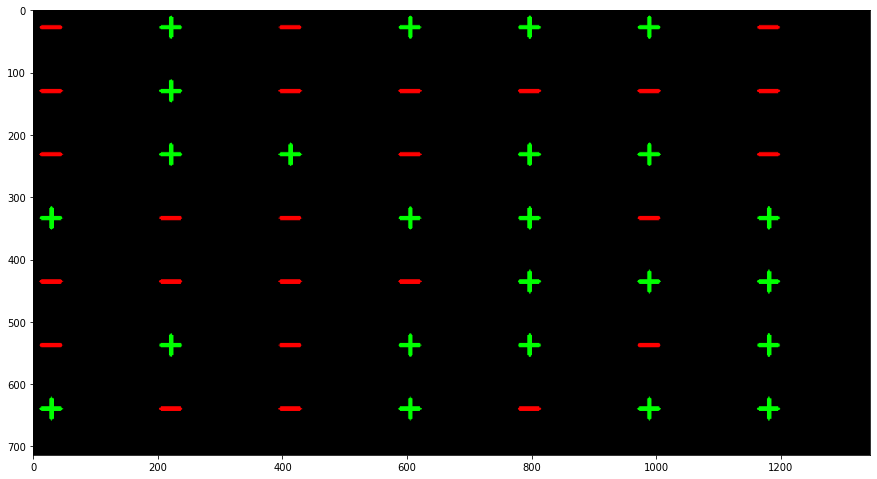

In [8]:
data_processing.pairs_montage(X_train, y_train)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Lambda, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Convolution2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2
# import tensorflow_addons as tfa

In [10]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [11]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [15]:
def build_siamese_model(input_shape):

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    kernel_size = 3

    # CNN
    model = Sequential()

    # input layer
    model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

    model.add(Flatten())

    model.add(Dense(4096, activation='sigmoid'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    # return the model
    return siamese_net

In [16]:
model = build_siamese_model(config['IMG_SHAPE'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         17317248    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]             

In [17]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [18]:
optimizer = Adam(learning_rate=config['LEARNING_RATE'])
model.compile(loss=contrastive_loss, optimizer=optimizer)

In [19]:
trainX = np.expand_dims(X, axis=-1)
(X_train, y_train) = data_processing.make_pairs(trainX, y)
print(X_train.shape)
print(y_train.shape)
y_train = tf.cast(y_train, tf.float32)

(7200, 2, 64, 64, 1)
(7200, 1)


In [20]:
es = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=100, verbose=1)

history = model.fit(
	[X_train[:, 0], X_train[:, 1]], y_train[:],
	validation_split=config['VALIDATION_SPLIT'],
	batch_size=config['BATCH_SIZE'], 
	epochs=config['EPOCHS'],
    verbose=True,
	callbacks=[es])

Train on 6480 samples, validate on 720 samples
Epoch 1/400
6480/6480 [==============================] - 6s 959us/sample - loss: 0.2169 - val_loss: 0.2115
Epoch 2/400
6480/6480 [==============================] - 2s 349us/sample - loss: 0.1732 - val_loss: 0.1850
Epoch 3/400
6480/6480 [==============================] - 2s 342us/sample - loss: 0.1212 - val_loss: 0.1164
Epoch 4/400
6480/6480 [==============================] - 2s 345us/sample - loss: 0.0797 - val_loss: 0.1252
Epoch 5/400
6480/6480 [==============================] - 2s 346us/sample - loss: 0.0581 - val_loss: 0.1260
Epoch 6/400
6480/6480 [==============================] - 2s 344us/sample - loss: 0.0427 - val_loss: 0.1444
Epoch 7/400
6480/6480 [==============================] - 2s 343us/sample - loss: 0.0378 - val_loss: 0.1234
Epoch 8/400
6480/6480 [==============================] - 2s 346us/sample - loss: 0.0286 - val_loss: 0.1432
Epoch 9/400
6480/6480 [==============================] - 2s 345us/sample - loss: 0.0311 - val_los

In [21]:
model.save(paths['MODEL_PATH'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/siamese_model/assets


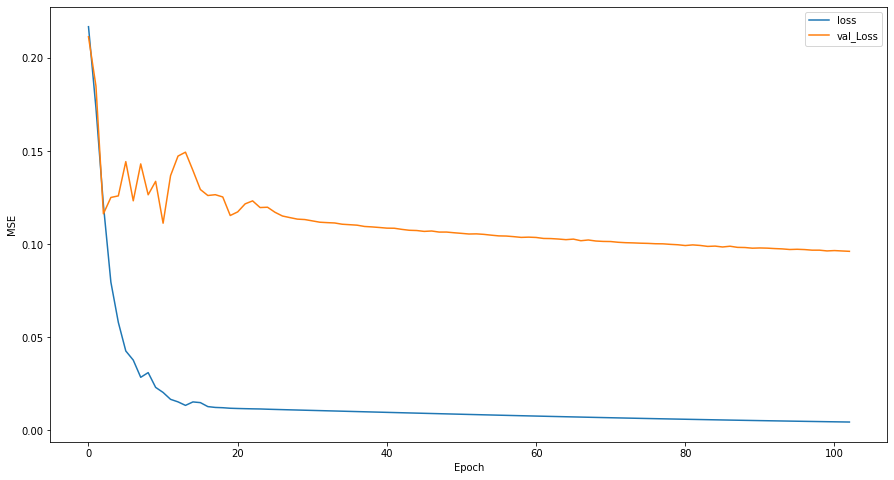

In [22]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.plot(model.history.history['loss'][:], label='loss')
plt.plot(model.history.history['val_loss'][:], label='val_Loss')
plt.legend()

In [23]:
tf.keras.backend.clear_session()

In [24]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

def read_imgs_from_dir(path_to_dir):
    images = []
    for filename in os.listdir(path_to_dir):
        image_path = os.path.join(path_to_dir, filename)
        image = cv2.imread(image_path, 0)
        images.append(image)

    return images

def draw_evaluation(sample, s_class, similarity):
    plt.figure(figsize=(4, 6))
    plt.title("Similarity: {:.2f}".format(similarity))
    pair = np.hstack((sample, s_class))
    plt.imshow(pair, cmap=plt.cm.gray)
    # plt.show()

def evaluate_data(model, path_classes, path_to_sample):
    # read sample
    sample = cv2.imread(path_to_sample, 0)
    sample = cv2.resize(sample, (64, 64), interpolation=cv2.INTER_LINEAR)
    if sample is None:
        sys.exit("Could not read the image.")

    sample_orig = sample.copy()

    # expand image dimensions, add 1 channel and batch dimension
    sample = np.expand_dims(sample, axis=-1)
    sample = np.expand_dims(sample, axis=0)

    # read classes we will compare our sample to
    classes = read_imgs_from_dir(path_classes)

    for single_class in classes:
        single_class_orig = single_class.copy()

        single_class = cv2.resize(single_class, (64, 64), interpolation=cv2.INTER_LINEAR)
        single_class_orig = cv2.resize(single_class_orig, (64, 64), interpolation=cv2.INTER_LINEAR)

        single_class = np.expand_dims(single_class, axis=-1)
        single_class = np.expand_dims(single_class, axis=0)

        # evaluate similarity
        prediction = model.predict([sample, single_class])
        similarity = prediction[0][0]
        draw_evaluation(sample_orig, single_class_orig, similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


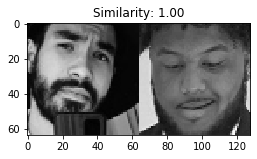

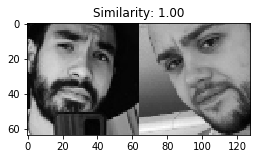

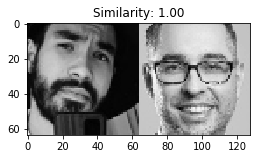

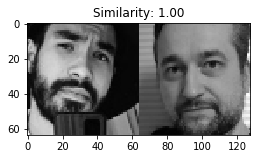

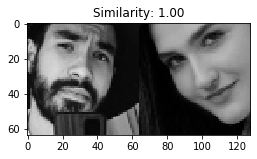

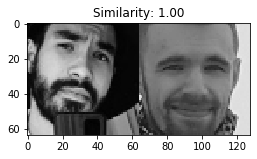

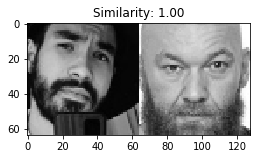

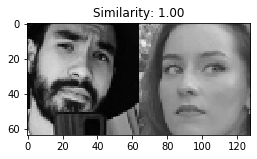

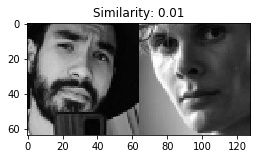

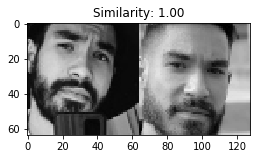

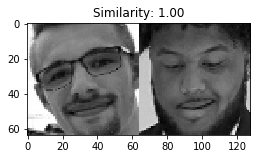

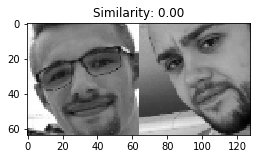

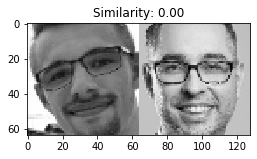

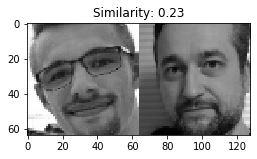

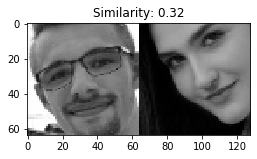

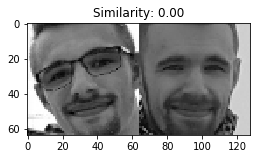

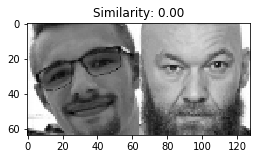

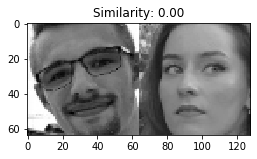

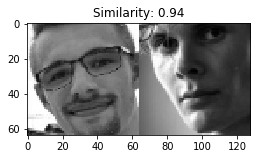

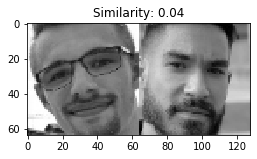

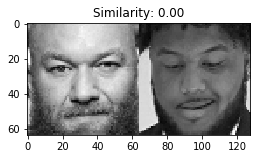

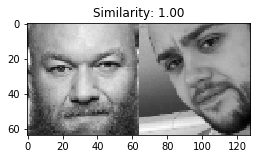

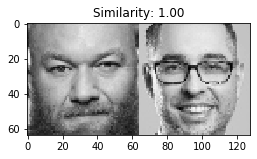

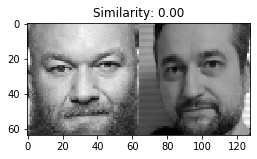

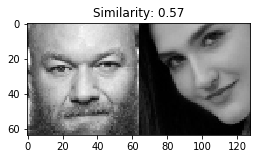

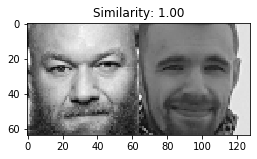

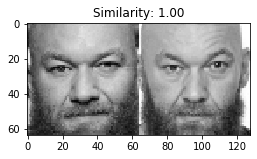

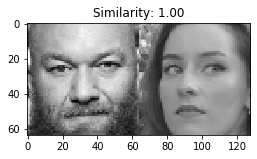

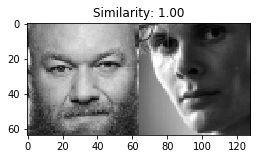

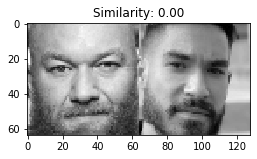

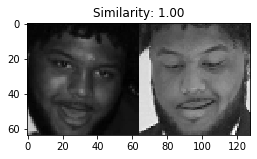

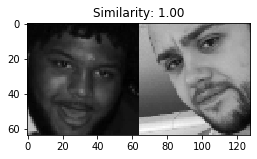

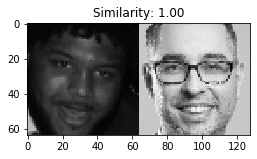

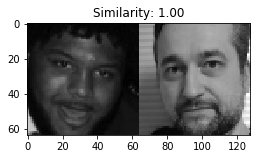

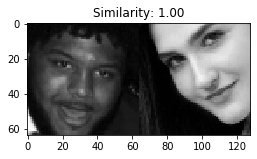

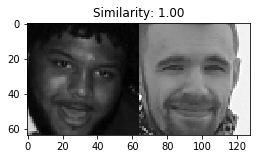

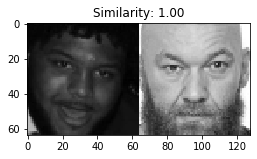

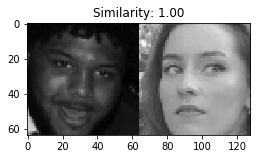

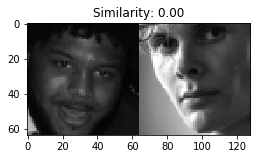

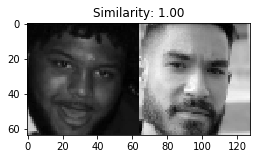

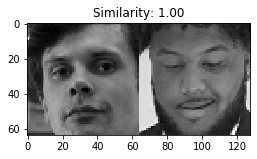

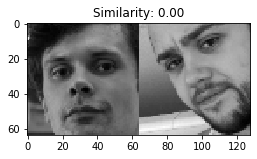

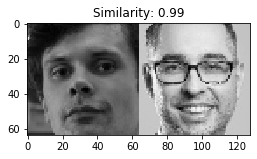

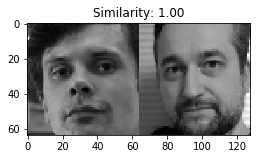

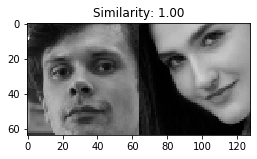

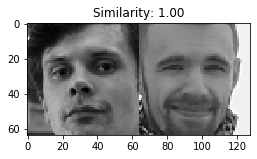

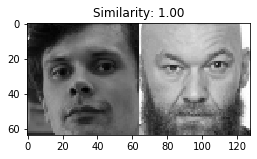

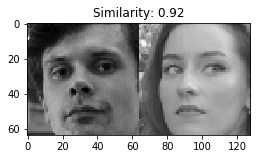

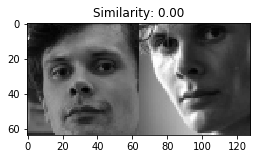

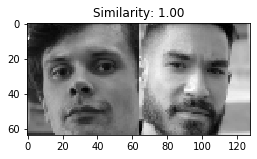

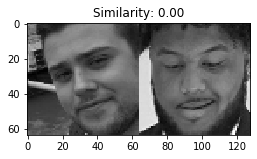

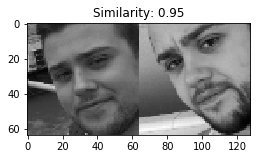

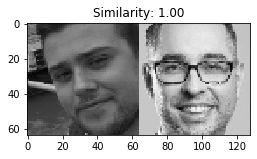

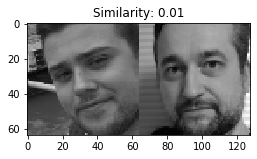

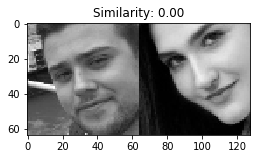

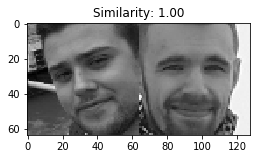

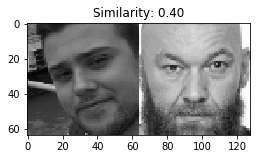

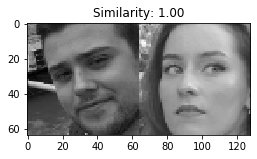

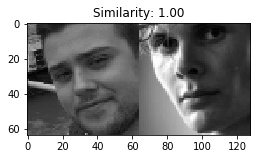

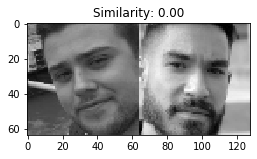

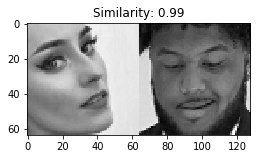

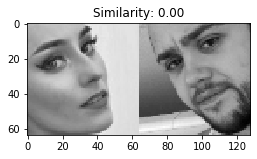

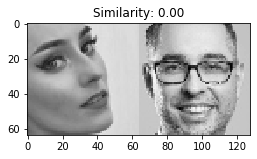

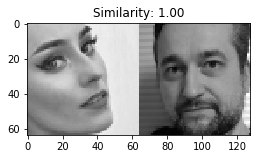

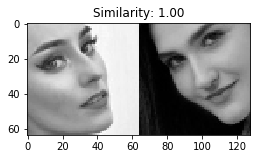

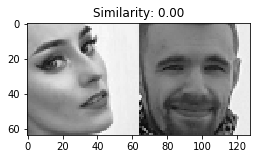

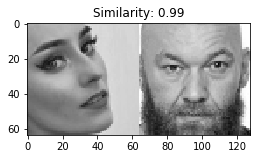

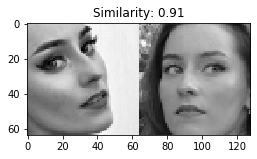

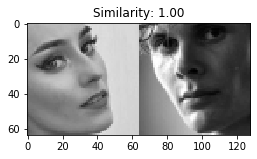

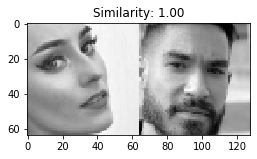

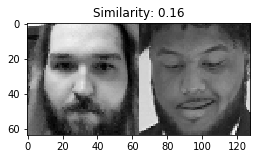

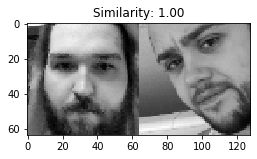

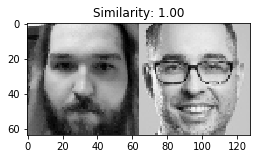

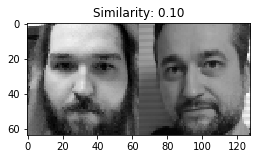

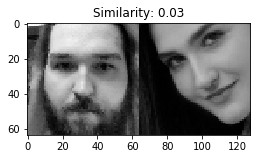

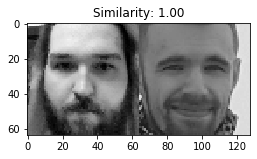

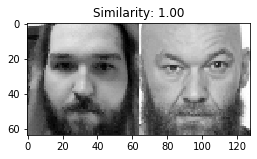

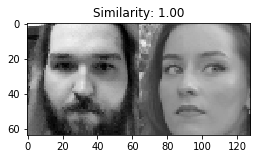

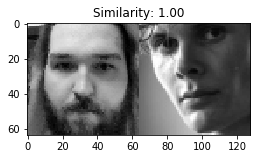

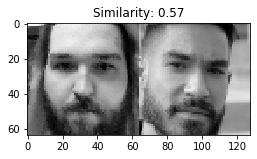

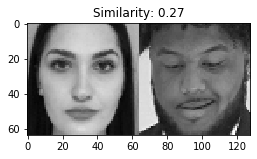

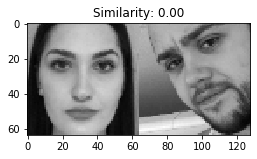

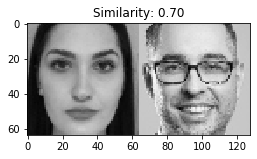

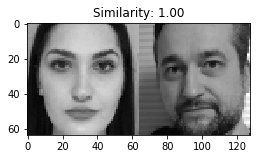

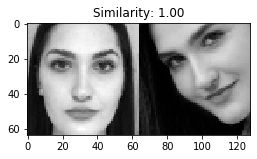

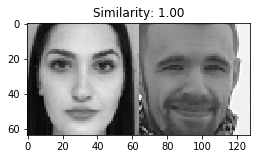

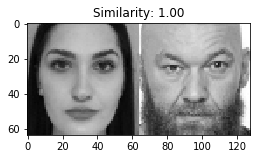

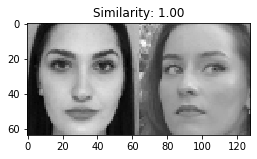

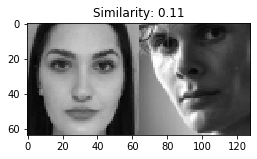

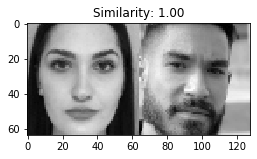

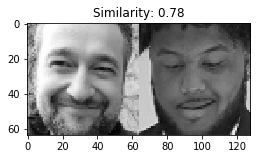

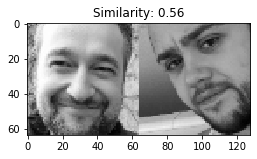

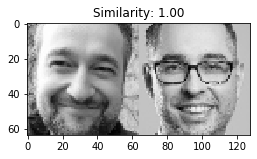

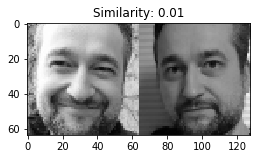

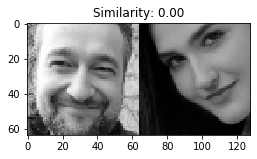

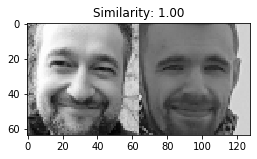

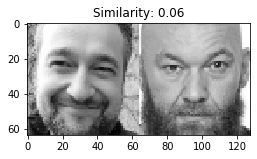

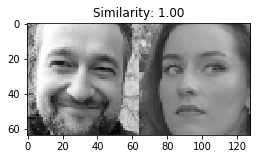

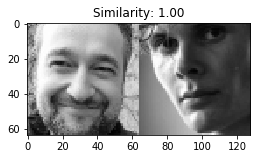

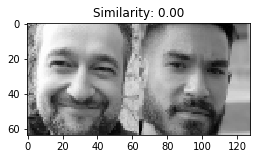

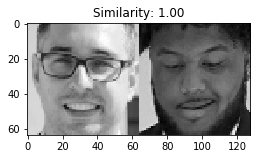

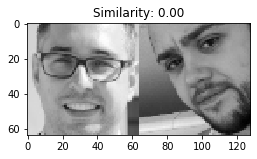

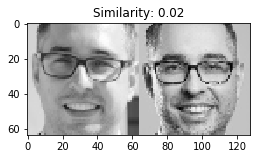

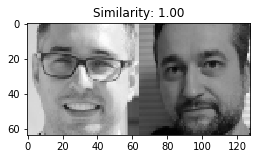

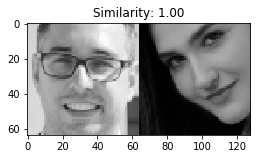

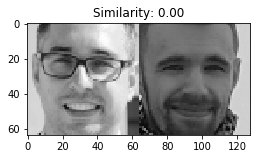

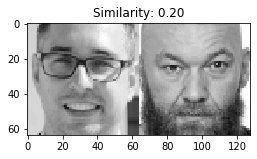

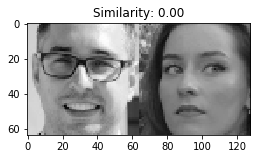

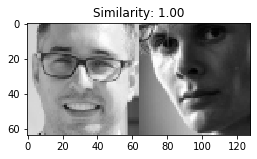

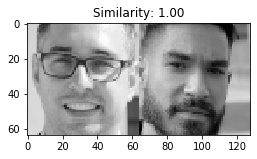

In [25]:
i = 100
for filename in os.scandir(paths['BASE_PATH']+paths['TEST_SAMPLES']):
    if filename.is_file() and '.DS_Store' not in filename.path:
        sample_name = filename.path
        evaluate_data(model, paths['BASE_PATH']+paths['TEST_CLASSES'], sample_name,)
        i -=1 
        if i<=0:
            break